## First, get the data into a useful format

In [1]:
import glob
import pandas as pd
import numpy as np
import datetime
from sklearn.linear_model import LogisticRegression
!pip install wget
import wget
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import copy
from sklearn.metrics import confusion_matrix
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import brier_score_loss
from sklearn import svm
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

from google.colab import drive
drive.mount('/content/drive')

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=bff19dd2b8baea82523b5808c3c53a311d2fe4f4b0956db266b48e50e450b996
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Set your directory path
#YOUR_DIRECTORY = '/content/drive/My Drive/ATMS597 Weather Climate Data Analysis/Module 6/Project 6/'  # Chu-Chun
YOUR_DIRECTORY = '/content/drive/My Drive/Colab Notebooks/Project_6/' # Jeff

In [3]:
# Read in datafile
features = pd.read_csv(YOUR_DIRECTORY + 'SESA_Avg_Precip_MJOIndices_SoilMoisture.csv', index_col = 'Unnamed: 0')
features.columns.name = 'Date'
# features = features.drop(columns = ['MJOPhase_OLR', 'MJOAmplitude_OLR', 'MJOPhase_OLR_lag5', 'MJOPhase_OLR_lag10', 'MJOPhase_OLR_lag15', 'MJOPhase_OLR_lag20',
#                                     'MJOPhase_OLR_lag25', 'MJOPhase_OLR_lag30', 'MJOAmplitude_OLR_lag5', 'MJOAmplitude_OLR_lag10', 'MJOAmplitude_OLR_lag15',
#                                     'MJOAmplitude_OLR_lag20', 'MJOAmplitude_OLR_lag25', 'MJOAmplitude_OLR_lag30'])
# features = features.drop(columns = ['SESA_Avg_ERA5_Soil_Moisture_Lev1', 'SESA_Avg_ERA5_Soil_Moisture_Lev2', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag5', 
#                                     'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag10', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag15', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag20',
#                                     'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag25', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag30', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag5', 
#                                     'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag10', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag15','SESA_Avg_ERA5_Soil_Moisture_Lev2_lag20', 
#                                     'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag25', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag30'])
features = features.dropna()
features.index = pd.to_datetime(features.index)

# Add year, month, day as features
# features['Year'] = features.index.year
# features['Month'] = features.index.month
# features['Day'] = features.index.day
#features = features[~features.index.month.isin([4, 5, 6, 7, 8, 9])]
#features = features[~features['MJOPhase_OLR'].isin([1, 7, 8])]
features

Date,SESA_Avg_GPCP_Precip,MJOPhase_OLR,MJOAmplitude_OLR,SESA_Avg_ERA5_Soil_Moisture_Lev1,SESA_Avg_ERA5_Soil_Moisture_Lev2,Year,Month,Day,MJOPhase_OLR_lag5,MJOPhase_OLR_lag10,MJOPhase_OLR_lag15,MJOPhase_OLR_lag20,MJOPhase_OLR_lag25,MJOPhase_OLR_lag30,MJOAmplitude_OLR_lag5,MJOAmplitude_OLR_lag10,MJOAmplitude_OLR_lag15,MJOAmplitude_OLR_lag20,MJOAmplitude_OLR_lag25,MJOAmplitude_OLR_lag30,SESA_Avg_ERA5_Soil_Moisture_Lev1_lag5,SESA_Avg_ERA5_Soil_Moisture_Lev1_lag10,SESA_Avg_ERA5_Soil_Moisture_Lev1_lag15,SESA_Avg_ERA5_Soil_Moisture_Lev1_lag20,SESA_Avg_ERA5_Soil_Moisture_Lev1_lag25,SESA_Avg_ERA5_Soil_Moisture_Lev1_lag30,SESA_Avg_ERA5_Soil_Moisture_Lev2_lag5,SESA_Avg_ERA5_Soil_Moisture_Lev2_lag10,SESA_Avg_ERA5_Soil_Moisture_Lev2_lag15,SESA_Avg_ERA5_Soil_Moisture_Lev2_lag20,SESA_Avg_ERA5_Soil_Moisture_Lev2_lag25,SESA_Avg_ERA5_Soil_Moisture_Lev2_lag30
1996-10-01,0.802094,4,0.4059,0.460888,0.468150,1996,10,1,6.0,6.0,5.0,5.0,5.0,1.0,0.6244,1.3798,1.0795,1.8319,0.5766,0.1080,0.492621,0.391118,0.432100,0.458614,0.449316,0.493759,0.491505,0.412240,0.429575,0.469598,0.461006,0.489766
1996-10-02,1.569398,3,0.4302,0.477875,0.478713,1996,10,2,5.0,6.0,5.0,5.0,5.0,5.0,0.0353,1.0692,1.2913,2.1190,0.8674,0.0653,0.492292,0.384300,0.450946,0.447974,0.438204,0.472939,0.491294,0.407437,0.442633,0.460626,0.451942,0.476704
1996-10-03,17.859299,2,0.4495,0.491203,0.490375,1996,10,3,4.0,6.0,5.0,5.0,5.0,5.0,0.2783,0.9147,1.2725,2.2432,1.2157,0.2746,0.496148,0.425672,0.435107,0.436272,0.501194,0.490613,0.493880,0.413252,0.438342,0.451673,0.478370,0.476392
1996-10-04,20.841913,2,0.3561,0.476827,0.483787,1996,10,4,4.0,6.0,5.0,5.0,5.0,5.0,0.6957,0.8338,1.3071,1.8349,1.4513,0.2632,0.484567,0.457851,0.419107,0.425025,0.483698,0.478728,0.485176,0.418785,0.430604,0.442405,0.491913,0.484252
1996-10-05,15.586549,1,0.5695,0.464411,0.472448,1996,10,5,4.0,6.0,5.0,5.0,5.0,5.0,0.6552,0.9839,1.4173,1.3773,1.6767,0.3715,0.473772,0.490829,0.406261,0.414356,0.468232,0.462643,0.479636,0.480346,0.422279,0.433058,0.478959,0.471617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-26,0.000000,2,0.3398,0.342145,0.373197,2019,11,26,1.0,8.0,7.0,5.0,4.0,3.0,1.0919,1.3378,1.9191,2.5294,1.8076,1.0424,0.352499,0.450357,0.462952,0.460949,0.427921,0.391507,0.389813,0.461422,0.458716,0.453349,0.428227,0.411377
2019-11-27,0.000000,1,0.6084,0.493269,0.444673,2019,11,27,2.0,8.0,7.0,5.0,5.0,3.0,0.9114,1.4613,1.9520,2.6146,1.9560,0.9014,0.339058,0.427612,0.444662,0.472428,0.409340,0.439617,0.380560,0.446058,0.448385,0.455172,0.420137,0.433978
2019-11-28,0.951774,1,0.7808,0.470274,0.462430,2019,11,28,3.0,8.0,8.0,6.0,5.0,4.0,0.6524,1.7816,1.9104,2.2046,2.2855,1.0290,0.361567,0.405825,0.427252,0.466658,0.422816,0.420148,0.381075,0.430731,0.439063,0.458762,0.421203,0.428518
2019-11-29,2.152993,1,0.9184,0.444326,0.449410,2019,11,29,3.0,8.0,8.0,6.0,5.0,4.0,0.5886,1.3550,1.6640,2.1225,2.4898,0.9807,0.362398,0.385543,0.494899,0.456993,0.447623,0.413893,0.379400,0.415153,0.481285,0.451284,0.431803,0.425161


In [4]:
features.describe()

Date,SESA_Avg_GPCP_Precip,MJOPhase_OLR,MJOAmplitude_OLR,SESA_Avg_ERA5_Soil_Moisture_Lev1,SESA_Avg_ERA5_Soil_Moisture_Lev2,Year,Month,Day,MJOPhase_OLR_lag5,MJOPhase_OLR_lag10,MJOPhase_OLR_lag15,MJOPhase_OLR_lag20,MJOPhase_OLR_lag25,MJOPhase_OLR_lag30,MJOAmplitude_OLR_lag5,MJOAmplitude_OLR_lag10,MJOAmplitude_OLR_lag15,MJOAmplitude_OLR_lag20,MJOAmplitude_OLR_lag25,MJOAmplitude_OLR_lag30,SESA_Avg_ERA5_Soil_Moisture_Lev1_lag5,SESA_Avg_ERA5_Soil_Moisture_Lev1_lag10,SESA_Avg_ERA5_Soil_Moisture_Lev1_lag15,SESA_Avg_ERA5_Soil_Moisture_Lev1_lag20,SESA_Avg_ERA5_Soil_Moisture_Lev1_lag25,SESA_Avg_ERA5_Soil_Moisture_Lev1_lag30,SESA_Avg_ERA5_Soil_Moisture_Lev2_lag5,SESA_Avg_ERA5_Soil_Moisture_Lev2_lag10,SESA_Avg_ERA5_Soil_Moisture_Lev2_lag15,SESA_Avg_ERA5_Soil_Moisture_Lev2_lag20,SESA_Avg_ERA5_Soil_Moisture_Lev2_lag25,SESA_Avg_ERA5_Soil_Moisture_Lev2_lag30
count,8454.000000,8454.000000,8454.000000,8454.000000,8454.000000,8454.000000,8454.000000,8454.000000,8454.000000,8454.000000,8454.000000,8454.000000,8454.000000,8454.000000,8454.000000,8454.000000,8454.000000,8454.000000,8454.000000,8454.000000,8454.000000,8454.000000,8454.000000,8454.000000,8454.000000,8454.000000,8454.000000,8454.000000,8454.000000,8454.000000,8454.000000,8454.000000
mean,5.315542,4.444642,1.281097,0.437010,0.438054,2007.824817,6.551928,15.727111,4.447480,4.448663,4.448427,4.445824,4.445943,4.445706,1.280993,1.281306,1.281107,1.281328,1.280549,1.279743,0.437060,0.437101,0.437119,0.437103,0.437129,0.437157,0.438087,0.438119,0.438129,0.438126,0.438155,0.438171
std,9.301523,2.298179,0.680950,0.041668,0.038278,6.691558,3.451729,8.802279,2.297113,2.296419,2.294558,2.293054,2.293005,2.293567,0.680830,0.680994,0.680810,0.680944,0.680622,0.680503,0.041665,0.041641,0.041635,0.041621,0.041606,0.041613,0.038296,0.038289,0.038282,0.038277,0.038261,0.038281
min,0.000000,1.000000,0.013900,0.288027,0.313392,1996.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.013900,0.013900,0.013900,0.013900,0.013900,0.013900,0.288027,0.288027,0.288027,0.288027,0.288027,0.288027,0.313392,0.313392,0.313392,0.313392,0.313392,0.313392
25%,0.000861,2.000000,0.755425,0.411405,0.412392,2002.000000,4.000000,8.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.755425,0.755575,0.755575,0.755900,0.755500,0.755125,0.411445,0.411495,0.411511,0.411527,0.411555,0.411566,0.412392,0.412426,0.412448,0.412473,0.412473,0.412473
50%,0.787701,4.000000,1.202900,0.445314,0.444136,2008.000000,7.000000,16.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,1.202900,1.203050,1.203250,1.203250,1.202800,1.202300,0.445359,0.445388,0.445419,0.445374,0.445397,0.445434,0.444142,0.444156,0.444145,0.444145,0.444145,0.444162
75%,6.592765,6.000000,1.714500,0.469560,0.468430,2014.000000,10.000000,23.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,1.714500,1.715075,1.714350,1.714875,1.713475,1.712800,0.469641,0.469674,0.469688,0.469641,0.469641,0.469692,0.468539,0.468547,0.468551,0.468547,0.468569,0.468617
max,69.611012,8.000000,4.414800,0.504710,0.504882,2019.000000,12.000000,31.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,4.414800,4.414800,4.414800,4.414800,4.414800,4.414800,0.504710,0.504710,0.504710,0.504710,0.504710,0.504710,0.504882,0.504882,0.504882,0.504882,0.504882,0.504882


## Model Features and Labels

In [7]:
# Separating columns into features and labels, then performing randomized splitting into training (70%) and testing (30%) datasets
labels = features['SESA_Avg_GPCP_Precip'].to_numpy() # Y
feats = features.drop(columns = ['SESA_Avg_GPCP_Precip']).to_numpy() # X
train_features, test_features, train_labels, test_labels = train_test_split(feats, labels, test_size = 0.3, random_state = 42)

# Save feature list for variable importance later on
featlist = features.drop(columns = ['SESA_Avg_GPCP_Precip'])
feature_list = list(featlist.columns)
feature_list

['MJOPhase_OLR',
 'MJOAmplitude_OLR',
 'SESA_Avg_ERA5_Soil_Moisture_Lev1',
 'SESA_Avg_ERA5_Soil_Moisture_Lev2',
 'Year',
 'Month',
 'Day',
 'MJOPhase_OLR_lag5',
 'MJOPhase_OLR_lag10',
 'MJOPhase_OLR_lag15',
 'MJOPhase_OLR_lag20',
 'MJOPhase_OLR_lag25',
 'MJOPhase_OLR_lag30',
 'MJOAmplitude_OLR_lag5',
 'MJOAmplitude_OLR_lag10',
 'MJOAmplitude_OLR_lag15',
 'MJOAmplitude_OLR_lag20',
 'MJOAmplitude_OLR_lag25',
 'MJOAmplitude_OLR_lag30',
 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag5',
 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag10',
 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag15',
 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag20',
 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag25',
 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag30',
 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag5',
 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag10',
 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag15',
 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag20',
 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag25',
 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag30']

## Function to create climatological probability for Brier Skill Score (ONLY IF DOING CLASSIFICATION)

In [0]:
# Calculate climatology probability
# def climate_probability(label, shape):
#     clim = (np.size(np.where(label == 1)))/float(len(label))
#     probability = np.zeros((shape))
#     probability[:,0] = 1 - clim
#     probability[:,1] = clim
#     return probability

## Now run the Random Forest model!

In [0]:
# from sklearn.model_selection import RandomizedSearchCV

# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']

# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)

# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]

# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]

# # Method of selecting samples for training each tree
# bootstrap = [True, False]# Create the random grid

# random_grid = {'n_estimators': n_estimators,
#                'max_depth': max_depth,
#                'max_features': ['auto', 'sqrt'],
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

# from pprint import pprint
# pprint(random_grid)


# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestRegressor()

# # Random search of parameters, using 3 fold cross validation, search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# # Train the Random search model on training data
# rf_random.fit(train_features, train_labels)

In [0]:
# Best hyperparameters determined by random search of 300 hyperparameter combinations

#rf_random.best_params_
#n_estimators = 800, random_state = 42, max_depth = 100, max_features = 'sqrt', min_samples_leaf = 4, min_samples_split = 10, bootstrap = True

In [0]:
# Instantiate model
rf = RandomForestRegressor(n_estimators = 800, random_state = 42, max_depth = 100, max_features = 'sqrt', min_samples_leaf = 4, min_samples_split = 10, bootstrap = True)

# Choose the columns we want to use in the regression!!!
# column_names_tmax  = ['TMAX','TMIN','tmpc','dwpc','WMAX','day','Avg DWPDEP(C)','Max DWPDEP(C)','Avg LCLD(%)','Avg HCLD(%)','Avg PRES(hPa)','Avg 850hPa DWPDEP(C)','Max 850hPa TMPC',
#                       'Min 925hPa TMPC','Max 925hPa TMPC','Min 250hPa WSPD(m/s)','Min 850hPa WSPD(m/s)']
# train_vars_tmax = new_features.query('year < 2019')[column_names_tmax] # Get the columns for training
# test_vars_tmax = new_features.query('year == 2019')[column_names_tmax] # Get the columns for testing

# Use the random grid to search for best hyperparameters
# First create the base model to tune
#rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, search across 100 different combinations, and use all available cores
#rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Train the model on training data
rf.fit(train_features, train_labels);

In [9]:
# Use the forest's predict method on the test data
#best_random = rf_random.best_estimator_
predictions = rf.predict(test_features)

from math import sqrt
from sklearn.metrics import mean_squared_error
# Print out the root mean square error (rmse)
print('Root Mean Square Error:', round(sqrt(mean_squared_error(test_labels, predictions)), 2), 'mm')

Root Mean Square Error: 9.39 mm


In [10]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: SESA_Avg_ERA5_Soil_Moisture_Lev2 Importance: 0.044
Variable: MJOAmplitude_OLR     Importance: 0.043
Variable: MJOAmplitude_OLR_lag10 Importance: 0.043
Variable: SESA_Avg_ERA5_Soil_Moisture_Lev1 Importance: 0.042
Variable: MJOAmplitude_OLR_lag25 Importance: 0.042
Variable: MJOAmplitude_OLR_lag20 Importance: 0.041
Variable: MJOAmplitude_OLR_lag15 Importance: 0.04
Variable: MJOAmplitude_OLR_lag30 Importance: 0.04
Variable: SESA_Avg_ERA5_Soil_Moisture_Lev1_lag25 Importance: 0.04
Variable: MJOAmplitude_OLR_lag5 Importance: 0.039
Variable: SESA_Avg_ERA5_Soil_Moisture_Lev1_lag5 Importance: 0.038
Variable: SESA_Avg_ERA5_Soil_Moisture_Lev1_lag15 Importance: 0.038
Variable: SESA_Avg_ERA5_Soil_Moisture_Lev1_lag30 Importance: 0.038
Variable: SESA_Avg_ERA5_Soil_Moisture_Lev2_lag10 Importance: 0.038
Variable: SESA_Avg_ERA5_Soil_Moisture_Lev2_lag25 Importance: 0.038
Variable: SESA_Avg_ERA5_Soil_Moisture_Lev1_lag10 Importance: 0.037
Variable: SESA_Avg_ERA5_Soil_Moisture_Lev2_lag5 Importance:

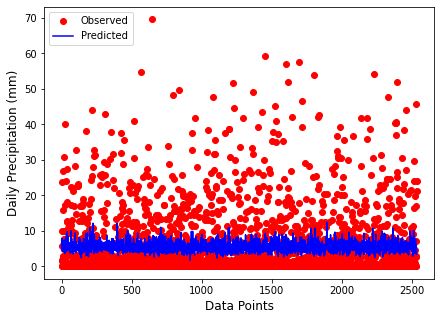

<Figure size 432x288 with 0 Axes>

In [12]:
# Plotting Prediction vs. Observed data

fig, ax = plt.subplots(figsize = (7, 5))
ax.plot(test_labels, 'ro', label = 'Observed')
ax.plot(predictions, 'b-', label = 'Predicted')
ax.set_xlabel('Data Points', fontsize = 12)
ax.set_ylabel('Daily Precipitation (mm)', fontsize=12)
plt.legend(loc = 2, fontsize = 10)
plt.show()

plt.tight_layout()
#fig.savefig(YOUR_DIRECTORY + 'SESA_Avg_PRCP_allVars_allMonths_allMJOPhases_testdata.png', dpi = 300)

In [0]:
## ONLY IF DOING CLASSIFICATION
## Determining predictive skill

# rf = RandomForestClassifier(n_estimators = 1600, random_state = 42, max_depth = 80, max_features = 'auto', min_samples_leaf = 1, min_samples_split = 3, bootstrap = True)
#rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
#rf.fit(train_features, train_labels)

# training_probability = rf.predict_proba(train_features)
# testing_probability = rf.predict_proba(test_features)

# print('Training Score: ' + str(rf.score(train_features, train_labels)))
# print('Testing Score: ' + str(rf.score(test_features, test_labels)))

# print('Training Brier Score: ' + str(brier_score_loss(train_labels, rf.predict(train_features))))
# print('Testing Brier Score: ' + str(brier_score_loss(test_labels, rf.predict(test_features))))

In [0]:
## ONLY IF DOING CLASSIFICATION
## Determining predictive skill

# training_climprob = climate_probability(train_labels, np.shape(training_probability))
# testing_climprob = climate_probability(test_labels, np.shape(testing_probability))

# # Calculate the Brier Skill Score for training and testing data
# training_bss = 1 - (brier_score_loss(train_labels, training_probability[:, 1]) / brier_score_loss(train_labels, training_climprob[:, 1]))
# testing_bss = 1 - (brier_score_loss(test_labels, testing_probability[:, 1]) / brier_score_loss(test_labels, testing_climprob[:, 1]))

# print('Training Brier Skill Score: ' + str(training_bss))
# print('Testing Brier Skill Score: ' + str(testing_bss))